# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
## Introduction

For this project, I will be working to understand the results of an A/B test run by a fictional e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Now, read in the `ab_data.csv` data. Store it in `df`.

In [5]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The number of rows in the dataset.

In [6]:
df.shape[0]

294478

The number of unique users in the dataset.

In [7]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [8]:
df['converted'].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't match.

In [9]:
df.query('group == "treatment" & landing_page != "new_page"').shape[0] + df.query('landing_page == "new_page" & group != "treatment"').shape[0]

3893

Confirming that none of the rows have missing values.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if this row truly received the new or old page.

Store new dataframe in `df2`.

In [11]:
df2 = df.query('(group == "control" & landing_page == "old_page") | (group == "treatment" & landing_page == "new_page")')

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

The number of unique `user_id`s in `df2`.

In [13]:
df2['user_id'].nunique()

290584

There is one `user_id` repeated in `df2`.

In [14]:
df2['user_id'].value_counts()

773192    2
630732    1
811737    1
797392    1
795345    1
801490    1
799443    1
787157    1
793302    1
817882    1
842446    1
815835    1
805596    1
803549    1
809694    1
807647    1
895712    1
840399    1
836301    1
899810    1
834242    1
936604    1
934557    1
940702    1
938655    1
830144    1
828097    1
832195    1
838348    1
821956    1
         ..
734668    1
736717    1
730574    1
775632    1
771538    1
642451    1
773587    1
783828    1
785877    1
779734    1
781783    1
759256    1
726472    1
748999    1
746950    1
753093    1
751044    1
740803    1
738754    1
744897    1
742848    1
634271    1
632222    1
636316    1
630169    1
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

Row information for the repeat `user_id`.

In [15]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove one of the rows with a duplicate `user_id`, but keep dataframe as `df2`.

In [16]:
df2 = df2.drop([2893])
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


The probability of an individual converting regardless of the page they receive.

In [17]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, the probability they converted.

In [18]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, the probability they converted.

In [19]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

The probability that an individual received the new page.

In [20]:
df2.query('landing_page == "new_page"')['user_id'].nunique() / df2['user_id'].nunique()

0.5000619442226688

Looking at the probabilities above, it does not look like the treatment page leads to more conversions. However, we can do a hypothesis test to confirm this more rigorously.

<a id='ab_test'></a>
### Part II - A/B Test

For now, we assume that we need to make the decision just based on all the data provided. If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, our null and alternative hypotheses will be as shown below:

Null hypothesis: **$p_{new}$** <= **$p_{old}$**

Alternative hypothesis: **$p_{new}$** > **$p_{old}$**

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the `converted` success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the `converted` rate in `ab_data.csv` regardless of the page.

Use a sample size for each page equal to the ones in `ab_data.csv`.

Perform the sampling distribution for the difference in `converted` between the two pages over 10,000 iterations of calculating an estimate from the null.

The conversion rate for `p_new` under the null.

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

The conversion rate for `p_old` under the null.

In [22]:
p_old = p_new
p_old

0.11959708724499628

`n_new`, the number of individuals in the treatment group.

In [23]:
n_new = df2.query('group == "treatment"')['user_id'].nunique()
n_new

145310

`n_old`, the number of individuals in the control group.

In [24]:
n_old = df2.query('group == "control"')['user_id'].nunique()
n_old

145274

Simulate `n_new` transactions with a conversion rate of `p_new` under the null.  Store these `n_new` 1's and 0's in `new_page_converted`.

In [25]:
new_page_converted = np.random.choice([0, 1], size = n_new, p = [1 - p_new, p_new])
new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

Simulate `n_old` transactions with a conversion rate of `p_old` under the null.  Store these `n_old` 1's and 0's in `old_page_converted`.

In [26]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [1 - p_old, p_old])
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

Find `p_new` - `p_old` for the simulated values.

In [27]:
new_page_converted.mean() - old_page_converted.mean()

0.00040393353617322603

Create 10,000 `p_new` - `p_old` values using the same simulation process above. Store all 10,000 values in a NumPy array called `p_diffs`.

In [28]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

Plot a histogram of the `p_diffs`.

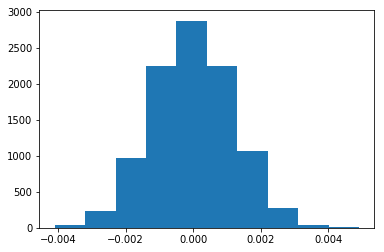

In [29]:
plt.hist(p_diffs);

The histogram looks how we would expect. The difference in conversion rates in the actual data is close to zero, and this aligns with the peak in the sampling distribution being around zero.

The proportion of the `p_diffs` that are greater than the actual difference observed in `ab_data.csv` is calculated below.

In [30]:
actual_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
print(f"actual_diff: {actual_diff}")

print("p-value: {}".format((p_diffs > actual_diff).mean()))

actual_diff: -0.0015782389853555567
p-value: 0.9043


The number above is the p-value. It is the proportion of the sampling distribution of the difference in conversion rates, for the new vs old landing pages, that is greater than the observed difference. The p-value is large, so we will not reject the null hypothesis. This calculation suggests that there is no significant difference in conversion rate between the new and old landing pages.

We could also use a built-in to achieve similar results. Below, I'll calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['user_id'].nunique()
convert_new = df2.query('group == "treatment" & converted == 1')['user_id'].nunique()
n_old = df2.query('group == "control"')['user_id'].nunique()
n_new = df2.query('group == "treatment"')['user_id'].nunique()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now use `stats.proportions_ztest` to compute the test statistic and p-value.

In [32]:
import statsmodels.stats.proportion as sp

stat, pval = sp.proportions_ztest([convert_new, convert_old], [n_new, n_old], value = 0, alternative = 'larger')
print(f"stat: {stat}, p-value: {pval}")

stat: -1.3109241984234394, p-value: 0.9050583127590245


The z-score says that the observed difference in conversion rate between new and old landing pages is 1.31 standard deviations less than the mean, relative to the sampling distribution. The p-value from the built-in function is the same as what we got in the previous calculation. It has the same meaning: over 90% of the sampling distribution is greater than the observed difference. Hence, the built-in function has the same conclusion that we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will analyze the A/B test using logistic regression.

The goal is to use statsmodels to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in `df2` a column for the intercept, and create a dummy variable column for which page each user received.  Add an `intercept` column, as well as an `ab_page` column, which is 1 when an individual receives the `treatment` and 0 if `control`.

In [33]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])

Use statsmodels to instantiate the regression model on the columns created above, then fit the model using these  columns to predict whether or not an individual converts. 

In [34]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary of the model below.

In [35]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-04 16:16 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

The p-value associated with ab_page is 0.1899, so it does not meet the 0.05 Type I error threshold. We would fail to reject the null hypothesis if using this model.

In the regression model, the null hypothesis is that the type of landing page does not have an effect on whether a user converts. Meanwhile the alternative hypothesis is that the landing page does have an effect.

In Part II above, the null hypothesis was that the conversion rate for the new landing pages was less than or equal to the conversion rate for the old landing page. Then the alternative hypothesis was that the new landing page's conversion rate was greater than that for the old landing page.

The different null and alternative hypotheses in each case resulted in different p-values.

Considering other factors in the model could potentially result in a better fit. If the factors are non-linear or have interactions with each other, one disadvantage is that the coefficients have less real-world meaning. A potential pitfall to look out for when including multiple factors is collinearity. This occurs when one factor depends on another, and it can result in a misleading model.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We will read in the `countries.csv` dataset and merge together the datasets on the appropriate rows.

In [36]:
df_countries = pd.read_csv('countries.csv')
print(df_countries['country'].value_counts())

df_final = df2.set_index('user_id').join(df_countries.set_index('user_id'))
df_final[['CA', 'UK', 'US']] = pd.get_dummies(df_final['country'])

logit_mod_final = sm.Logit(df_final['converted'], df_final[['intercept', 'ab_page', 'CA', 'UK']])
results_final = logit_mod_final.fit()
results_final.summary2()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64
Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-04 16:16 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

None of the factors had statistical significance below the 0.05 Type I error threshold. However when adding the country data to the model, we see that the effect of a user being in CA vs the US has a greater impact on conversion rate than the type of landing page. On the other hand, the effect of a user being in the UK vs the US had a lower impact relative to the landing page. These conclusions are based on the p-values in the model summary.

Though we looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 

In [37]:
df_final['ab_page_CA'] = df_final['ab_page'] * df_final['CA']
df_final['ab_page_UK'] = df_final['ab_page'] * df_final['UK']

logit_mod_interaction = sm.Logit(df_final['converted'], df_final[['intercept', 'ab_page', 'CA', 'UK', 'ab_page_CA', 'ab_page_UK']])
results_interaction = logit_mod_interaction.fit()
results_interaction.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-04 16:16 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page_CA   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_page_UK    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

In this latest model, the interaction factors between country and landing page had more statistical significance than the country alone. The landing page itself was the best predictor of conversion. However, none of the factors had statistical significance below the 0.05 Type I error threshold.

<a id='conclusion'></a>
### Conclusion

In this project, we performed a few different analyses: hypothesis test using bootstrapping, the statsmodels module's proportions_ztest built-in method, and logistic regression. Each analysis showed that the difference in conversion rate between the old and new landing pages was not statistically significant. Hence, the recommendation is not to reject the null hypothesis. In other words, the company should stick to using the old landing page and end the A/B test.